In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result

In [3]:
def avg_pos_deg(nodes):
    return pos_A[nodes, :][:, nodes].sum() / nodes.shape[0]

def avg_neg_deg(nodes):
    return neg_A[nodes, :][:, nodes].sum() / nodes.shape[0]

def cohe(C1, C2):
    n1, n2 = C1.shape[0], C2.shape[0]
    cohe1 = pos_A[C1, :][:, C1].sum() / (n1 * (n1-1))
    cohe2 = pos_A[C2, :][:, C2].sum() / (n2 * (n2-1))
    return np.mean([cohe1, cohe2])

def oppo(C1, C2):
    return neg_A[C1, :][:, C2].sum() * 2 / C1.shape[0] / C2.shape[0]

def agreement(C1, C2):
    n_bad_pos = pos_A[C1, :][:, C2].sum() * 2
    n_bad_neg = neg_A[C1, :][:, C1].sum() + neg_A[C2, :][:, C2].sum()
    C = list(C1) + list(C2)
    n_total = pos_A[C, :][:, C].sum() + neg_A[C, :][:, C].sum()
    return 1 - (n_bad_pos + n_bad_neg) / n_total

def get_row_by_query(query):
    return df[df['query'] == query].iloc[0]

def show(q, **kwargs):
    r = get_row_by_query(q)
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=True, r=r, **kwargs)
    ax.set_title('q:{}, agr:{:.2f}, ham:{:.2f}, opp:{:.2f}, coh:{:.2f}'.format(q, r['agreement'], r['ham'], r['opp'], r['coh']))

In [4]:
graph = 'slashdot'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
A = nx.adj_matrix(g, weight='sign')
df = pd.read_pickle('outputs/{}.pkl'.format(graph))

In [5]:
pos_A, neg_A = pos_adj(A), neg_adj(A)

In [6]:
df['size1'] = df['C1'].apply(lambda d: d.shape[0])
df['size2'] = df['C2'].apply(lambda d: d.shape[0])
df['balancedness'] = np.minimum(df['size1'], df['size2']) / (df['size1'] + df['size2'])

## filtering

exclude those that:

- C1 or C2 is small (<10 nodes)
- k != 200

In [7]:
df = df[df['k'] == 200]
df = df[(df['size1'] > 10) & (df['size2'] > 10)]

## data fields to add

- query degree
- avg pos/neg degree inside C1|C2
- opposition between C1 and C2

In [8]:
df['qdeg'] = df['query'].apply(lambda n: g.degree(n))

In [9]:
df['posdeg1'] = df['C1'].apply(avg_pos_deg)
df['posdeg2'] = df['C2'].apply(avg_pos_deg)
df['negdeg1'] = df['C1'].apply(avg_neg_deg)
df['negdeg2'] = df['C2'].apply(avg_neg_deg)

In [10]:
df['coh'] = df[['C1', 'C2']].apply(lambda d: cohe(d['C1'], d['C2']), axis=1)
df['opp'] = df[['C1', 'C2']].apply(lambda d: oppo(d['C1'], d['C2']), axis=1)
df['ham'] = 2 * df['coh'] * df['opp'] / (df['coh'] + df['opp'])

In [11]:
df['agreement'] = df[['C1', 'C2']].apply(lambda d: agreement(d['C1'], d['C2']), axis=1)

In [12]:
df[['size1', 'size2', 'posdeg1', 'posdeg2', 'negdeg1', 'negdeg2', 'opp', 'agreement']].head(3)

,size1,size2,posdeg1,posdeg2,negdeg1,negdeg2,opp,agreement
17,41,25,0.926829,1.680000,0.0,0.0,0.013659,1.0
25,32,17,1.250000,0.235294,0.0,0.0,0.011029,1.0
61,71,23,1.464789,0.782609,0.0,0.0,0.015922,1.0


In [13]:
fields_to_show = ['query', 'best_beta', 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp']

## top-k by HAM

In [14]:
df[fields_to_show].sort_values(by='ham', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
9904,46608,0.481203,23,11,0.621622,0.172830,0.180237,0.166008
11915,46617,0.442379,26,14,0.765306,0.140361,0.133187,0.148352
4101,6988,0.794466,11,15,1.000000,0.126164,0.105195,0.157576


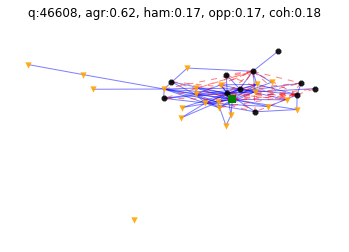

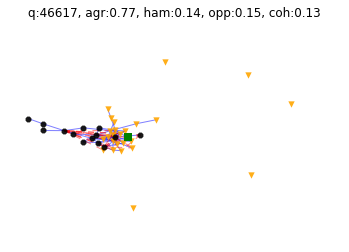

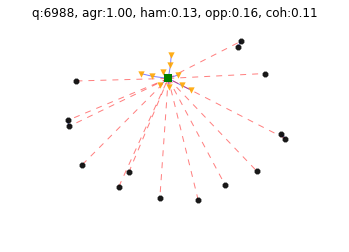

In [22]:
queries = df.sort_values(by='ham', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q)

## top-k by agreement

In [16]:
df[fields_to_show].sort_values(by='agreement', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
17,31731,0.667845,41,25,1.0,0.021124,0.046585,0.013659
8227,8833,0.754717,89,40,1.0,0.006927,0.015098,0.004494
7883,1213,0.807229,21,23,1.0,0.059278,0.056691,0.062112


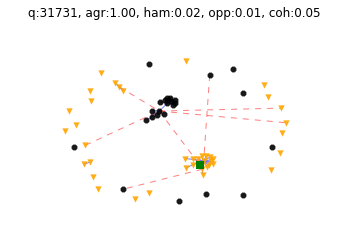

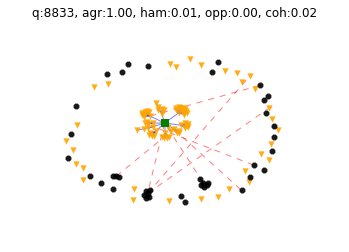

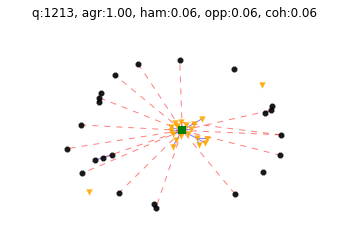

In [17]:
queries = df.sort_values(by='agreement', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q, use_lcc=False)

## top-k by opposition

In [18]:
df[fields_to_show].sort_values(by='opp', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
9671,42131,0.534050,13,18,1.0,0.125224,0.074786,0.384615
3061,38141,0.531915,27,13,1.0,0.085148,0.051282,0.250712
5171,1301,0.808429,11,15,1.0,0.101603,0.068831,0.193939


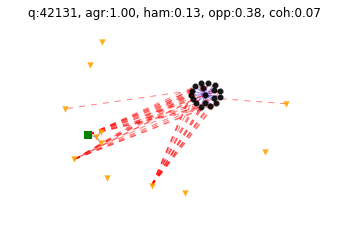

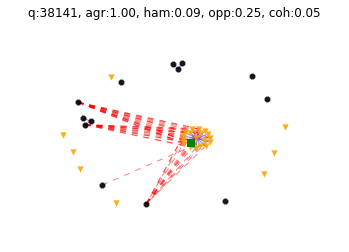

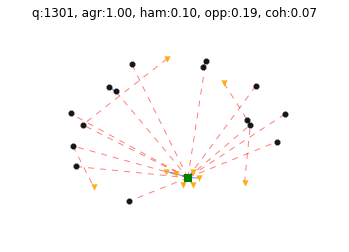

In [19]:
queries = df.sort_values(by='opp', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q, use_lcc=False)

## top-k by coherence

In [20]:
df[fields_to_show].sort_values(by='coh', ascending=False).head(3)

,query,best_beta,size1,size2,agreement,ham,coh,opp
9904,46608,0.481203,23,11,0.621622,0.172830,0.180237,0.166008
1765,57888,0.459954,41,26,1.000000,0.036019,0.141398,0.020638
11915,46617,0.442379,26,14,0.765306,0.140361,0.133187,0.148352


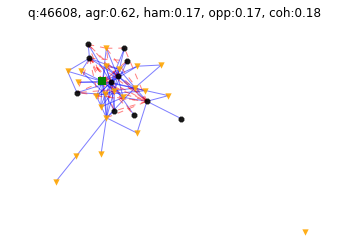

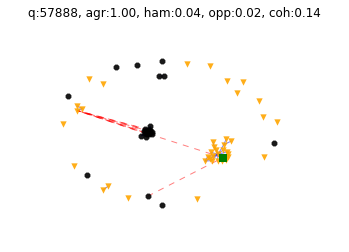

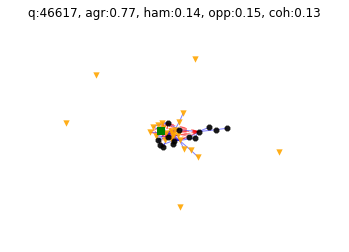

In [21]:
queries = df.sort_values(by='coh', ascending=False).head(3)['query'].tolist()
for q in queries:
    show(q)